<a href="https://colab.research.google.com/github/Tam107/BDM/blob/main/EE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cài đặt thư viện seaborn (nếu chưa có) và nhập các thư viện cần thiết
!pip install seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Đặt seed để đảm bảo kết quả có thể tái hiện
np.random.seed(42)
tf.random.set_seed(42)

print("Đã nhập tất cả thư viện cần thiết.")

Đã nhập tất cả thư viện cần thiết.


# Entity Embedding Training

Cell 2: Tải và Kiểm Tra Dataset

In [5]:
# Tải dataset lên Google Colab

print("Read dataset autos.csv")
data = pd.read_csv('autos.csv',encoding='latin1')

# Kiểm tra các cột trong dataset
expected_columns = [
    'dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest', 'vehicleType',
    'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer',
    'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated',
    'nrOfPictures', 'postalCode', 'lastSeen'
]

missing_columns = [col for col in expected_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"Các cột bị thiếu trong dataset: {missing_columns}")

# Hiển thị 5 dòng đầu tiên của dataset
print("\n5 dòng đầu tiên của dataset:")
print(data.head())

# Hiển thị thông tin cơ bản về dataset
print("\nThông tin dataset:")
print(data.info())

Read dataset autos.csv

5 dòng đầu tiên của dataset:
           dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOf

Cell 3: Tiền Xử Lý Dữ Liệu

In [6]:
# Định nghĩa các cột số và phân loại
numerical_cols = [
    'kilometer', 'yearOfRegistration', 'powerPS', 'monthOfRegistration',
    'nrOfPictures', 'postalCode'
]
categorical_cols = [
    'brand', 'gearbox', 'seller', 'vehicleType', 'fuelType', 'offerType',
    'abtest', 'model', 'notRepairedDamage'
]
target = 'price'

# Xử lý cột datetime: Trích xuất năm từ 'dateCreated'
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
numerical_cols.append('adYear')

# Loại bỏ các cột không sử dụng
data = data.drop(columns=['name', 'dateCrawled', 'lastSeen', 'dateCreated'])

# Xử lý giá trị thiếu
data = data.dropna(subset=numerical_cols + categorical_cols + [target])

# Chuẩn hóa các cột số bằng Min-Max Scaling
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Mã hóa các cột phân loại bằng LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Chuẩn bị dữ liệu đầu vào
X_num = data[numerical_cols].values
X_cat = [data[col].values for col in categorical_cols]
y = data[target].values

# Hiển thị dữ liệu sau khi tiền xử lý
print("\nDữ liệu số sau khi chuẩn hóa (5 dòng đầu tiên):")
print(pd.DataFrame(X_num, columns=numerical_cols).head())

print("\nDữ liệu phân loại sau khi mã hóa (5 dòng đầu tiên):")
for i, col in enumerate(categorical_cols):
    print(f"{col}: {X_cat[i][:5]}")

<ipython-input-6-c769420f7960>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
<ipython-input-6-c769420f7960>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = le.fit_transform(data[col].astype(str))



Dữ liệu số sau khi chuẩn hóa (5 dòng đầu tiên):
   kilometer  yearOfRegistration  powerPS  monthOfRegistration  nrOfPictures  \
0   1.000000            0.842593  0.00375             0.500000           0.0   
1   0.586207            0.907407  0.00345             0.583333           0.0   
2   1.000000            0.787037  0.00510             0.833333           0.0   
3   1.000000            0.870370  0.00545             0.666667           0.0   
4   0.241379            0.648148  0.00250             0.583333           0.0   

   postalCode  adYear  
0    0.909796     1.0  
1    0.600115     1.0  
2    0.330614     1.0  
3    0.667586     1.0  
4    0.184785     1.0  

Dữ liệu phân loại sau khi mã hóa (5 dòng đầu tiên):
brand: [37 31  2 25 37]
gearbox: [1 1 1 1 1]
seller: [1 1 1 1 1]
vehicleType: [4 4 6 2 6]
fuelType: [1 3 1 1 1]
offerType: [0 0 0 0 0]
abtest: [1 1 1 1 1]
model: [118 103  11   8  40]
notRepairedDamage: [1 1 0 1 1]


Cell 4: Chia Dữ Liệu Thành Tập Huấn Luyện và Kiểm Tra

In [7]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Sử dụng các chỉ số để chia X_num, X_cat và y
X_num_train, X_num_test = X_num[train_idx], X_num[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
X_cat_train = [X_cat[i][train_idx] for i in range(len(categorical_cols))]
X_cat_test = [X_cat[i][test_idx] for i in range(len(categorical_cols))]

# Hiển thị kích thước của các tập dữ liệu
print("Kích thước tập huấn luyện:")
print(f"X_num_train: {X_num_train.shape}")
print(f"X_cat_train: {[arr.shape for arr in X_cat_train]}")
print(f"y_train: {y_train.shape}")

print("\nKích thước tập kiểm tra:")
print(f"X_num_test: {X_num_test.shape}")
print(f"X_cat_test: {[arr.shape for arr in X_cat_test]}")
print(f"y_test: {y_test.shape}")

Kích thước tập huấn luyện:
X_num_train: (208764, 7)
X_cat_train: [(208764,), (208764,), (208764,), (208764,), (208764,), (208764,), (208764,), (208764,), (208764,)]
y_train: (208764,)

Kích thước tập kiểm tra:
X_num_test: (52192, 7)
X_cat_test: [(52192,), (52192,), (52192,), (52192,), (52192,), (52192,), (52192,), (52192,), (52192,)]
y_test: (52192,)


Cell 5: Xây Dựng Mô Hình Entity Embedding

In [8]:
# Xây dựng mô hình Entity Embedding
# Đầu vào cho các cột số
num_input = Input(shape=(len(numerical_cols),), name='num_input')

# Đầu vào và Entity Embedding cho các cột phân loại
cat_inputs = []
cat_embeddings = []
embedding_sizes = {}

for i, col in enumerate(categorical_cols):
    n_unique = data[col].nunique()
    embedding_size = min(8, max(1, (n_unique - 1)))
    embedding_sizes[col] = embedding_size
    print(f"Kích thước embedding cho {col}: {embedding_size} (n_unique = {n_unique})")

    cat_input = Input(shape=(1,), name=f'cat_input_{col}')
    cat_embed = Embedding(input_dim=n_unique, output_dim=embedding_size, name=f'embed_{col}')(cat_input)
    cat_flat = Flatten()(cat_embed)
    cat_inputs.append(cat_input)
    cat_embeddings.append(cat_flat)

# Kết hợp các đầu vào số và phân loại
concat = Concatenate()([num_input] + cat_embeddings)

# Mạng nơ-ron với các lớp ẩn
x = Dense(128, activation='relu')(concat)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear', name='output')(x)

# Định nghĩa và biên dịch mô hình
model = Model(inputs=[num_input] + cat_inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')

# Hiển thị cấu trúc mô hình
model.summary()

Kích thước embedding cho brand: 8 (n_unique = 39)
Kích thước embedding cho gearbox: 1 (n_unique = 2)
Kích thước embedding cho seller: 1 (n_unique = 2)
Kích thước embedding cho vehicleType: 7 (n_unique = 8)
Kích thước embedding cho fuelType: 6 (n_unique = 7)
Kích thước embedding cho offerType: 1 (n_unique = 2)
Kích thước embedding cho abtest: 1 (n_unique = 2)
Kích thước embedding cho model: 8 (n_unique = 250)
Kích thước embedding cho notRepairedDamage: 1 (n_unique = 2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cat_input_brand           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_gearbox         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_seller          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_vehicleType     │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_fuelType        │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_offerType       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_abtest          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_model           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cat_input_notRepairedDam… │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_brand (Embedding)   │ (None, 1, 8)           │            312 │ cat_input_brand[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_gearbox (Embedding) │ (None, 1, 1)           │              2 │ cat_input_gearbox[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_seller (Embedding)  │ (None, 1, 1)           │              2 │ cat_input_seller[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_vehicleType         │ (None, 1, 7)           │             56 │ cat_input_vehicleType… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embed_fuelType            │ (None, 1, 6)           │             42 │ cat_input_fuelType[0]… │
│ (Embedding)               │                        │                │                        │
├──────────────────────

 Total params: 16,117 (62.96 KB)

 Trainable params: 16,117 (62.96 KB)

 Non-trainable params: 0 (0.00 B)

Cell 6: Huấn Luyện Mô Hình

Epoch 1/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 221076045824.0000 - val_loss: 3834944512.0000
Epoch 2/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 221018996736.0000 - val_loss: 3830410752.0000
Epoch 3/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 220991422464.0000 - val_loss: 3828751616.0000
Epoch 4/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 220974219264.0000 - val_loss: 3828393984.0000
Epoch 5/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 220963569664.0000 - val_loss: 3827549184.0000
Epoch 6/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 220958097408.0000 - val_loss: 3826198528.0000
Epoch 7/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 220953821184.0000 - val_loss: 3824474880.0000
Epoch 8/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 220949659648.0000 - val_loss: 3822903040.0000
Epoch 9/50
6524/6524 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 220945874944.0000 - val_loss: 3821886976.0000
Epoch 10/50
6524/65

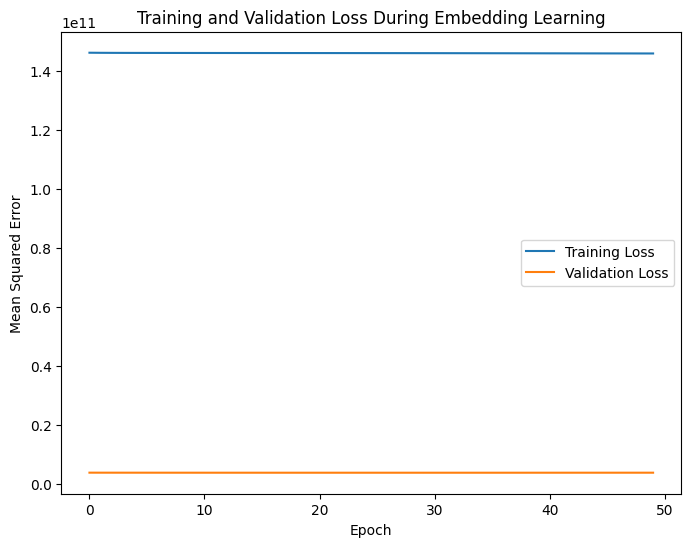

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [9]:
# Huấn luyện mô hình
history = model.fit(
    [X_num_train] + X_cat_train, y_train,
    validation_data=([X_num_test] + X_cat_test, y_test),
    epochs=50, batch_size=32, verbose=1
)

# Vẽ biểu đồ loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss During Embedding Learning')
plt.legend()
plt.show()

# Lưu biểu đồ loss
plt.savefig('loss_curve.png')
files.download('loss_curve.png')

Cell 7: Trích Xuất và Lưu Trữ Embeddings


Entity Embeddings cho 'brand' (5 danh mục đầu tiên):
[[ 2.6962891e+00  3.4960630e+00 -6.4729261e+00 -6.7664294e+00
   5.3255234e+00  6.9005914e+00  2.9161492e-01  4.4336324e+00]
 [-2.9709798e-01 -2.1450146e-01 -4.1877609e-02  1.6180362e-01
  -1.5424833e-01 -2.3859049e-01  5.8863498e-02  5.2298112e-03]
 [ 1.7952756e+00  7.3016387e-01 -5.0817723e+00 -4.2435546e+00
   3.0008988e+00  4.1380658e+00  2.5066979e+00  3.1642327e+00]
 [-1.1537038e+00  3.4942300e+00 -2.9543455e+00 -4.4383087e+00
   3.6273484e+00  4.6617088e+00  1.4479225e+00  2.4869952e+00]
 [-1.2505039e+00  5.4166541e+00 -4.5915308e+00 -7.0496397e+00
   5.5649104e+00  7.6375871e+00  1.9546549e-01  3.6301281e+00]]


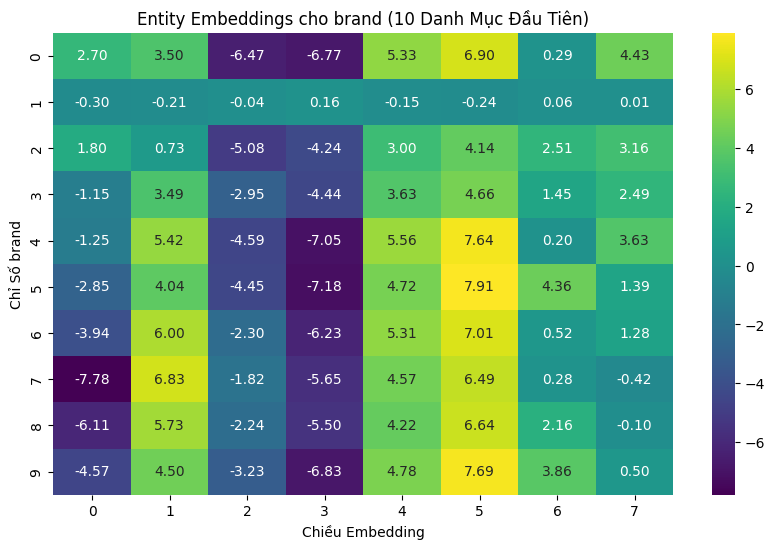

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'gearbox' (5 danh mục đầu tiên):
[[-1.6310419]
 [ 2.1890948]]


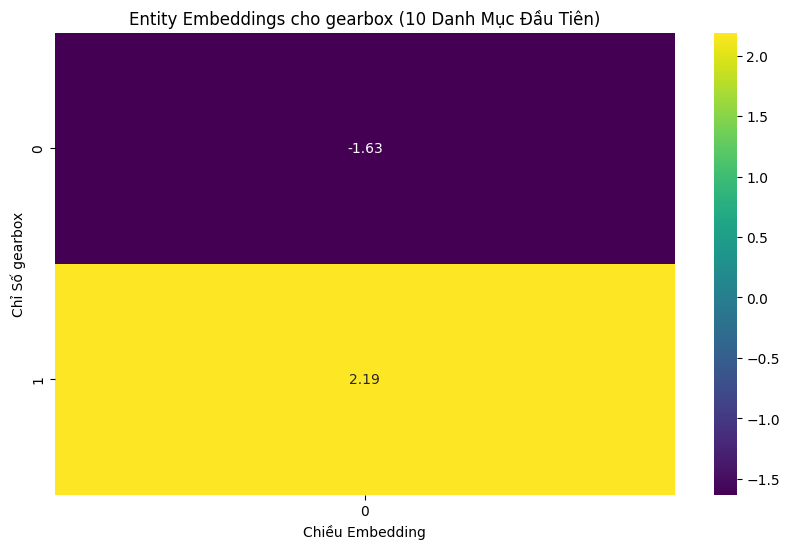

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'seller' (5 danh mục đầu tiên):
[[1.1218318]
 [3.1350338]]


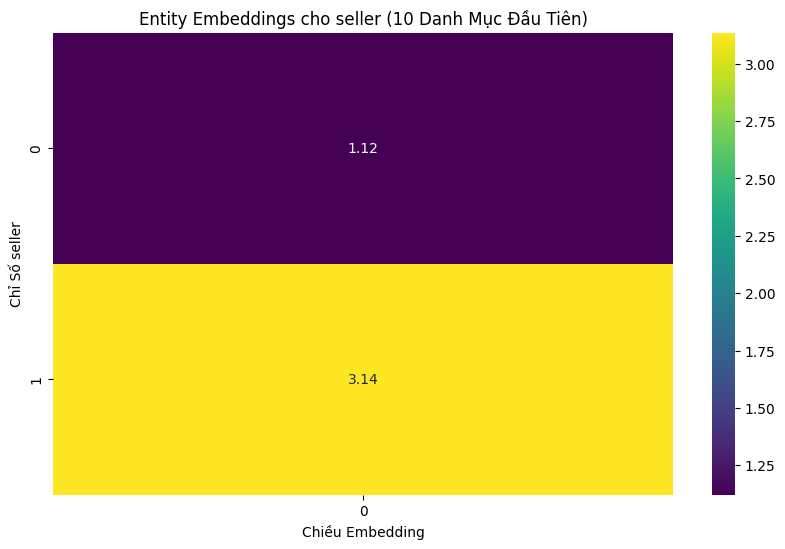

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'vehicleType' (5 danh mục đầu tiên):
[[ 5.56071    -6.5435724  -1.1817702   7.4318147   2.0094292   1.0052434
  -7.4998918 ]
 [ 3.2702801  -3.426574   -3.3822546   3.4612002   3.2597258   3.2833834
  -3.506622  ]
 [ 1.8319254  -1.4904795  -4.9509172   0.4987649   4.759698    5.6398506
  -0.33456805]
 [ 0.11649327 -0.18959053 -0.17134646  0.18837109  0.11733457  0.15699533
  -0.14195202]
 [ 4.9214606  -6.058468    0.16679782  7.893191    0.63799775 -1.4355588
  -6.99778   ]]


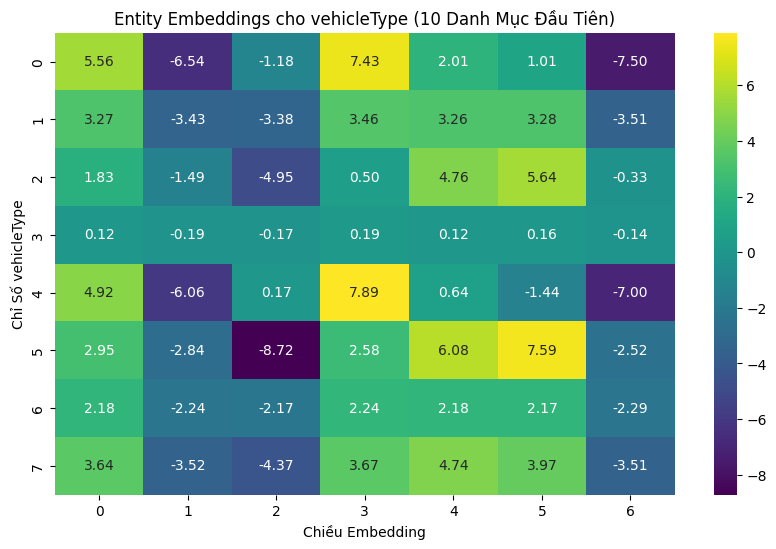

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'fuelType' (5 danh mục đầu tiên):
[[ 1.2711174  -2.1445858  -2.402969   -1.3318063   2.5364757  -2.9857316 ]
 [ 0.8876816   1.0495367  -0.30391383 -0.63371736  0.44210327  1.1553875 ]
 [ 0.09744201  1.2492468   0.13309774 -0.41913307 -0.2137816   1.9464527 ]
 [-1.4693751  -1.546659    1.4940276   1.4761118  -1.452264   -1.5815012 ]
 [ 1.3803262   0.5940834  -1.8331244  -1.5875825   1.7025282   0.7921483 ]]


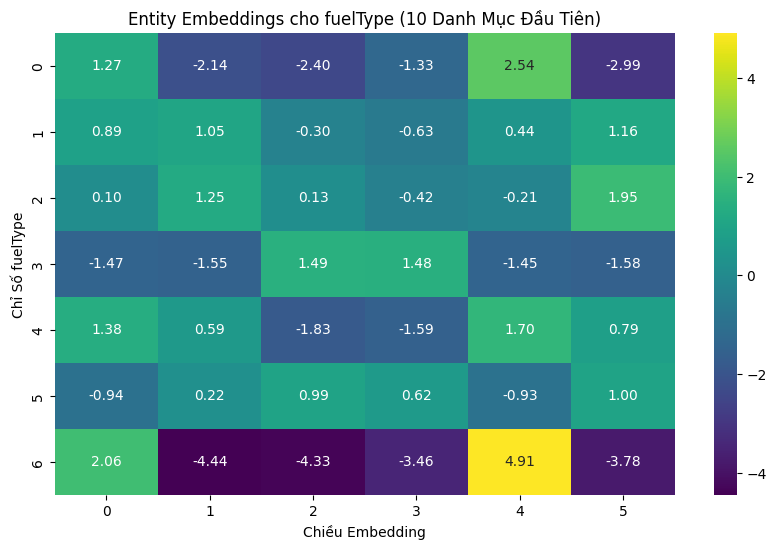

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'offerType' (5 danh mục đầu tiên):
[[ 3.0341675]
 [-1.6485984]]


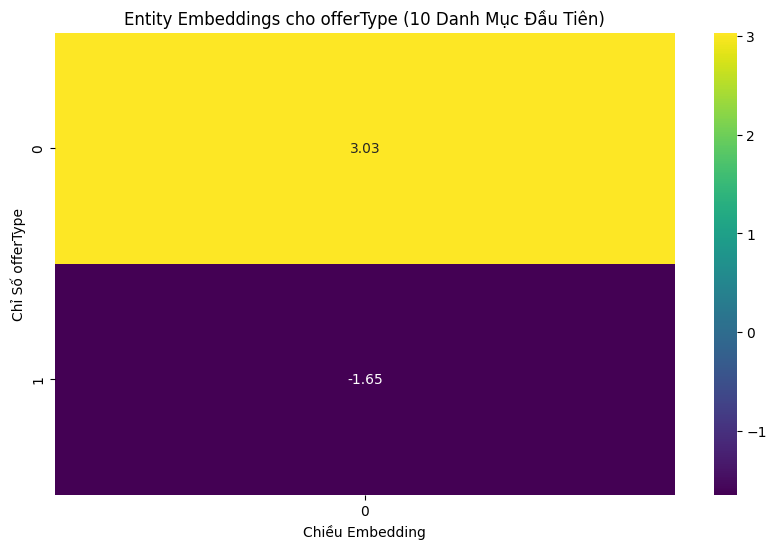

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'abtest' (5 danh mục đầu tiên):
[[-0.6250982]
 [ 0.810605 ]]


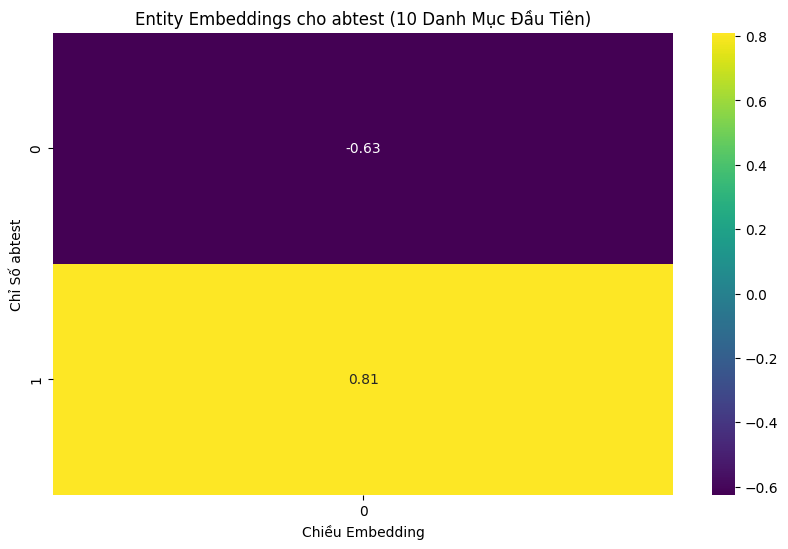

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'model' (5 danh mục đầu tiên):
[[ 1.6316832  -6.208264    2.5094965  -2.4707792  -7.061119   -6.998073
   0.9730831   0.21058267]
 [ 1.0838854  -1.4862067   1.7138195  -0.7482592  -2.813385   -1.3082271
   1.1993712   0.8452717 ]
 [ 0.6293648  -3.8298588   1.7337773  -1.9661864  -4.387409   -3.1734695
   1.6708661   0.6933981 ]
 [ 0.7267297  -3.8540192   2.003826   -0.7100797  -4.807558   -3.0090468
   2.696548    1.5255888 ]
 [-0.5912557  -2.39843    -0.10423904 -2.2554173  -1.6383767  -0.8707481
   0.08470567  0.8071185 ]]


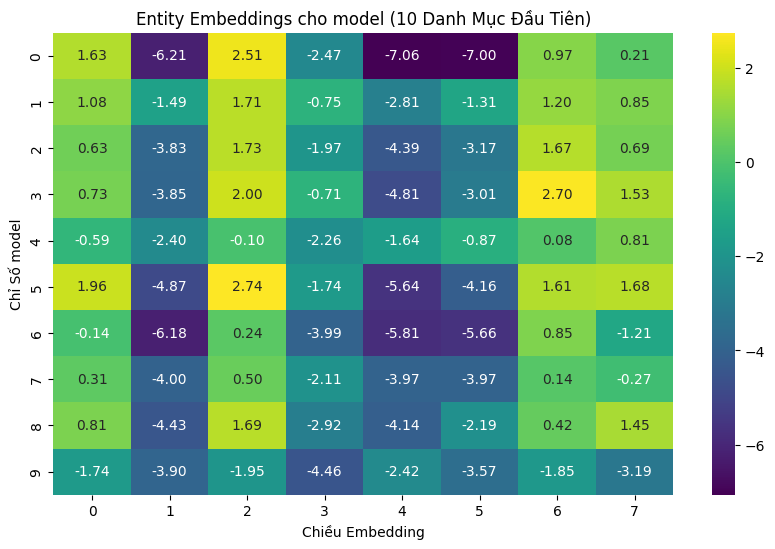

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Entity Embeddings cho 'notRepairedDamage' (5 danh mục đầu tiên):
[[ 3.4651527]
 [-2.1377313]]


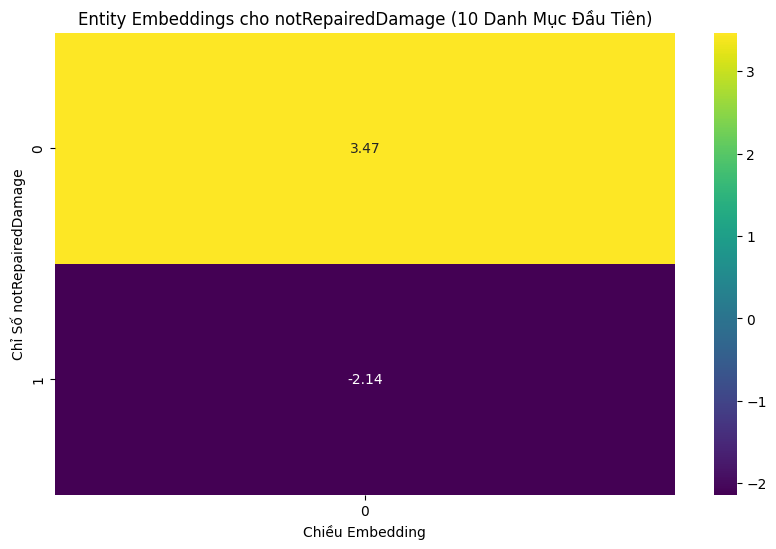

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'brand' vào brand_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'gearbox' vào gearbox_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'seller' vào seller_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'vehicleType' vào vehicleType_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'fuelType' vào fuelType_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'offerType' vào offerType_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'abtest' vào abtest_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'model' vào model_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Đã lưu embeddings cho 'notRepairedDamage' vào notRepairedDamage_embeddings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Trích xuất và lưu trữ embeddings
embeddings_dict = {}
for col in categorical_cols:
    embedding_layer = model.get_layer(f'embed_{col}')
    embedding_weights = embedding_layer.get_weights()[0]
    embeddings_dict[col] = embedding_weights

    # Hiển thị embeddings mẫu
    print(f"\nEntity Embeddings cho '{col}' (5 danh mục đầu tiên):")
    print(embedding_weights[:5])

    # Vẽ heatmap cho embeddings
    plt.figure(figsize=(10, 6))
    sns.heatmap(embedding_weights[:10], cmap='viridis', annot=True, fmt='.2f')
    plt.title(f"Entity Embeddings cho {col} (10 Danh Mục Đầu Tiên)")
    plt.xlabel('Chiều Embedding')
    plt.ylabel(f'Chỉ Số {col}')
    plt.show()

    # Lưu và tải xuống heatmap
    plt.savefig(f'{col}_embeddings_heatmap.png')
    files.download(f'{col}_embeddings_heatmap.png')
    plt.close()

# Lưu embeddings vào file CSV
for col in categorical_cols:
    embedding_df = pd.DataFrame(embeddings_dict[col])
    le = label_encoders[col]
    category_names = le.inverse_transform(range(len(le.classes_)))
    embedding_df.index = category_names[:embedding_df.shape[0]]
    embedding_df.to_csv(f'{col}_embeddings.csv')
    print(f"Đã lưu embeddings cho '{col}' vào {col}_embeddings.csv")
    files.download(f'{col}_embeddings.csv')

Cell 8: Hiển Thị và Lưu Trữ Dữ Liệu Đã Xử Lý

In [11]:
# Hiển thị dữ liệu đã xử lý cho một vài mẫu
sample_size = 5
X_num_sample = X_num_test[:sample_size]
X_cat_sample = [X_cat_test[i][:sample_size] for i in range(len(categorical_cols))]

# Tạo DataFrame để lưu dữ liệu đã xử lý
processed_data = pd.DataFrame(X_num_sample, columns=numerical_cols)

# Thêm embeddings cho từng mẫu
for i, col in enumerate(categorical_cols):
    embeddings = embeddings_dict[col]
    cat_embeddings_sample = np.array([embeddings[idx] for idx in X_cat_sample[i]])
    for dim in range(embedding_sizes[col]):
        processed_data[f'{col}_embed_{dim}'] = cat_embeddings_sample[:, dim]

# Thêm tên danh mục gốc để tham khảo
for i, col in enumerate(categorical_cols):
    le = label_encoders[col]
    processed_data[f'{col}_original'] = le.inverse_transform(X_cat_sample[i])

# Hiển thị dữ liệu đã xử lý
print("\nDữ Liệu Đã Xử Lý (Một Vài Mẫu với Các Đặc Trưng Số Đã Chuẩn Hóa và Embeddings):")
print(processed_data)

# Lưu dữ liệu đã xử lý vào file CSV
processed_data.to_csv('processed_data_sample.csv', index=False)
files.download('processed_data_sample.csv')


Dữ Liệu Đã Xử Lý (Một Vài Mẫu với Các Đặc Trưng Số Đã Chuẩn Hóa và Embeddings):
   kilometer  yearOfRegistration  powerPS  monthOfRegistration  nrOfPictures  \
0   1.000000            0.861111  0.00375             1.000000           0.0   
1   0.827586            0.814815  0.00000             0.500000           0.0   
2   1.000000            0.824074  0.00000             0.916667           0.0   
3   1.000000            0.833333  0.00450             0.416667           0.0   
4   0.827586            0.787037  0.00450             0.416667           0.0   

   postalCode  adYear  brand_embed_0  brand_embed_1  brand_embed_2  ...  \
0    0.576462     1.0      -1.099109       0.660739      -6.148740  ...   
1    0.477444     1.0      -0.212188       2.513757      -2.948056  ...   
2    0.057060     1.0      -3.035062       3.836550      -4.652554  ...   
3    0.173020     1.0      -1.283672       0.704264      -0.404101  ...   
4    0.976883     1.0      -1.099109       0.660739      -6.148

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# MLP Training